In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-approval-prediction/credit_record.csv
/kaggle/input/credit-card-approval-prediction/application_record.csv


In [3]:
!pip install pycaret --ignore-installed llvmlite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 562.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 12.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 16.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 14.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 21.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [5]:
# imports 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import pycaret
from pycaret.classification import *

## Load Data

In [6]:
app_df = pd.read_csv('/kaggle/input/credit-card-approval-prediction/application_record.csv')
credit_df = pd.read_csv('/kaggle/input/credit-card-approval-prediction/credit_record.csv')

In [7]:
# explore shape of Data
print('shape of application data', app_df.shape)
print('shape of credit data',credit_df.shape)
print('unique ID in application record',len(set(app_df['ID'])))
print('unique ID in credit record',len(set(credit_df['ID'])))
print('unique ID in two tables share',len(set(app_df['ID']).intersection(set(credit_df['ID']))))
print('Number of New customer',len(set(app_df['ID']))- len(set(app_df['ID']).intersection(set(credit_df['ID']))))


shape of application data (438557, 18)
shape of credit data (1048575, 3)
unique ID in application record 438510
unique ID in credit record 45985
unique ID in two tables share 36457
Number of New customer 402053


### Data Merging

In [8]:
#sorting IDs
app_df = app_df.sort_values('ID')
credit_df = credit_df.sort_values('ID')
#Map the status to bad or good
credit_df['STATUS_BINARY'] = credit_df['STATUS']
credit_df = credit_df.replace({'STATUS_BINARY' :{'C' : 'Good','X' : 'Good','0' : 'Bad', '1' : 'Bad','2' : 'Bad','3' : 'Bad','4' : 'Bad','5' : 'Bad'}})

In [9]:
result_df = credit_df.value_counts(subset=['ID', 'STATUS_BINARY']).unstack(fill_value=0).reset_index()
#decide the user is good or bad based on his/her history majority
result_df.loc[(result_df['Good'] / result_df['Bad'] >= 1), 'Status'] = 1
result_df.loc[(result_df['Good'] / result_df['Bad'] < 1 ), 'Status'] = 0
result_df['Status'] = result_df['Status'].astype(int)
result_df

STATUS_BINARY,ID,Bad,Good,Status
0,5001711,3,1,0
1,5001712,10,9,0
2,5001713,0,22,1
3,5001714,0,15,1
4,5001715,0,60,1
...,...,...,...,...
45980,5150482,12,6,0
45981,5150483,0,18,1
45982,5150484,12,1,0
45983,5150485,2,0,0


In [10]:
df = app_df.merge(result_df, how='inner', on=['ID'])
#define the rate of good debts for each user
df['rate'] = (df['Good']+0.1) / (df['Bad']+0.1)
df.drop(['Good','Bad'],axis=1,inplace = True)
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Status,rate
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,6.714286
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,6.238095
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1,3.253521
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1,1.476190
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1,51.000000


In [11]:
#Renaming columns to more friendly names
df.columns = ['ID', 'Gender', 'Car', 'Realty', 'Children', 'Income', 'Income_Type',
                        'Education_Type', 'Family_Status', 'Housing_Type',  'Age', 'Years_Experience' , 'Mobile_Phone', 'Work_Phone', 
                        'Phone', 'Email', 'Job_Title', 'Total_Family' , 'Status','rate']
df.head(5)

,ID,Gender,Car,Realty,Children,Income,Income_Type,Education_Type,Family_Status,Housing_Type,Age,Years_Experience,Mobile_Phone,Work_Phone,Phone,Email,Job_Title,Total_Family,Status,rate
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,6.714286
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,6.238095
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1,3.253521
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1,1.476190
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1,51.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                36457 non-null  int64  
 1   Gender            36457 non-null  object 
 2   Car               36457 non-null  object 
 3   Realty            36457 non-null  object 
 4   Children          36457 non-null  int64  
 5   Income            36457 non-null  float64
 6   Income_Type       36457 non-null  object 
 7   Education_Type    36457 non-null  object 
 8   Family_Status     36457 non-null  object 
 9   Housing_Type      36457 non-null  object 
 10  Age               36457 non-null  int64  
 11  Years_Experience  36457 non-null  int64  
 12  Mobile_Phone      36457 non-null  int64  
 13  Work_Phone        36457 non-null  int64  
 14  Phone             36457 non-null  int64  
 15  Email             36457 non-null  int64  
 16  Job_Title         25134 non-null  object

### EDA

In [16]:
df.groupby('Status')['Status'].count()/len(df)

Status
0    0.44584
1    0.55416
Name: Status, dtype: float64

<AxesSubplot:ylabel='Status'>

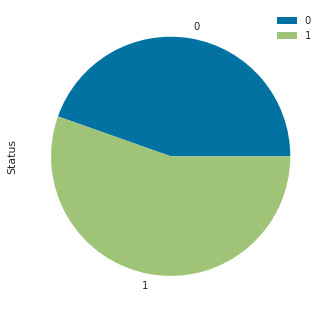

In [14]:
#How many good and bad history users ?
df.groupby('Status')['Status'].count().plot(kind='pie', y='Status',legend = True)

<AxesSubplot:ylabel='Gender'>

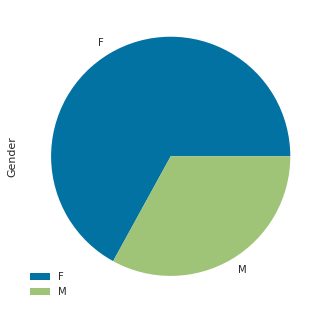

In [17]:
# what is the majority gender of users ?
df.groupby('Gender')['Gender'].count().plot(kind='pie', y='Gender',legend = True)

<AxesSubplot:xlabel='Income_Type'>

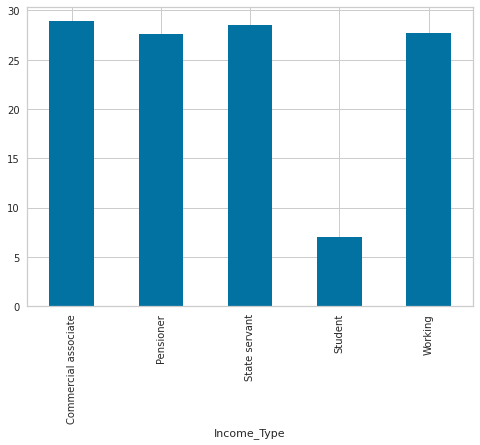

In [14]:
# How Features effect on the decision and comparison with the rate
df.groupby('Income_Type')['rate'].mean().plot(kind = 'bar')
# Students have the worst rates

<AxesSubplot:xlabel='Family_Status'>

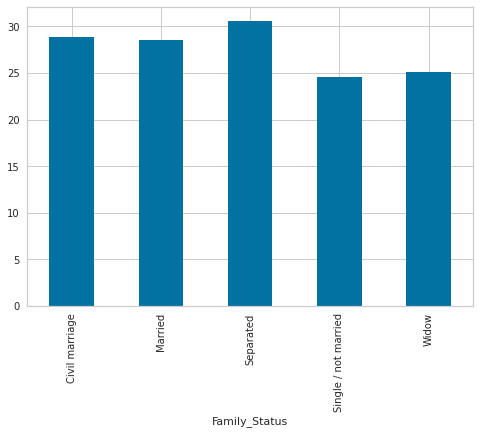

In [15]:
df.groupby('Family_Status')['rate'].mean().plot(kind = 'bar')
# Single has bad rate compared to married(the worst rates)

<AxesSubplot:xlabel='Car'>

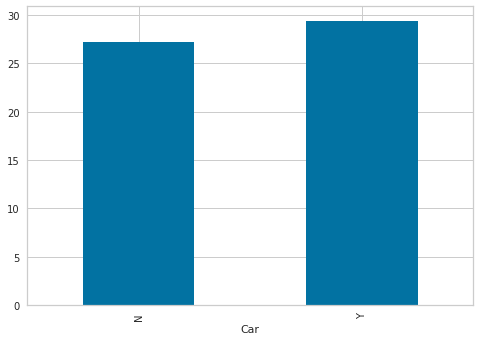

In [16]:
df.groupby('Car')['rate'].mean().plot(kind = 'bar')
#Users with cars have better rates

<AxesSubplot:xlabel='Total_Family'>

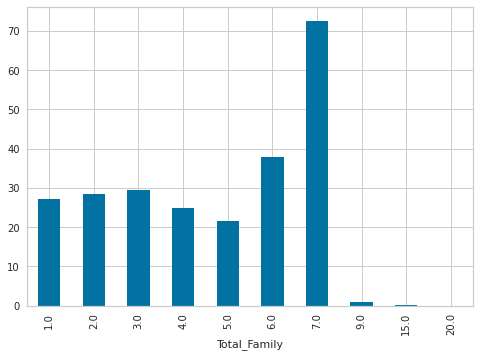

In [17]:
df.groupby('Total_Family')['rate'].mean().plot(kind = 'bar')
# Families with 7 members have good rate 

<AxesSubplot:xlabel='Education_Type'>

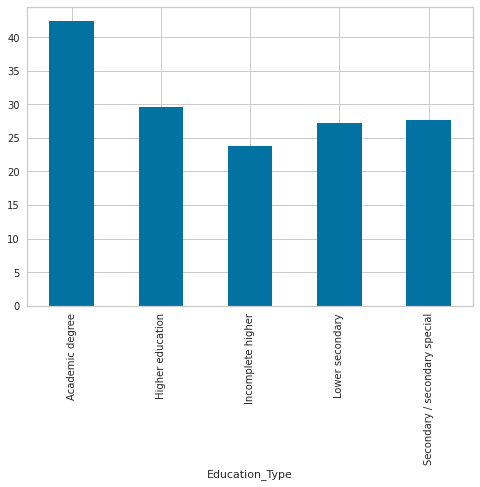

In [18]:
df.groupby('Education_Type')['rate'].mean().plot(kind = 'bar')
# Academic degree have good rates

<AxesSubplot:xlabel='Housing_Type'>

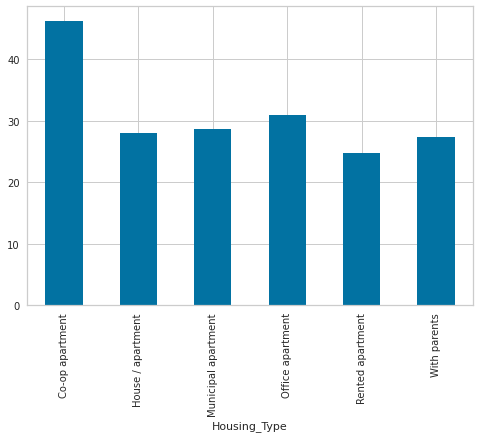

In [19]:
df.groupby('Housing_Type')['rate'].mean().plot(kind = 'bar')
# co-op apartment degree have good rates

no.of numerical columns =  12


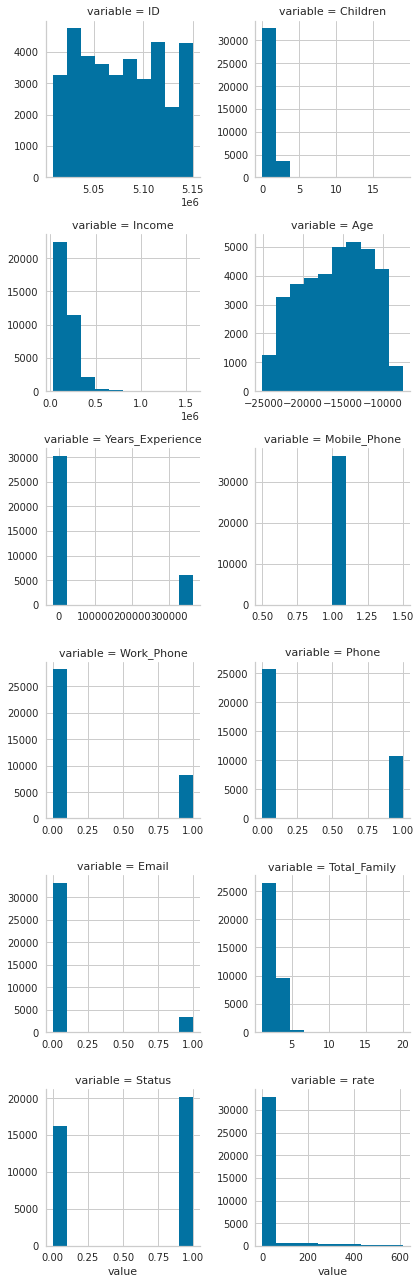

In [20]:
# extract numerical columns and plot histgram for it


numer_col = df.select_dtypes(include=['int64', 'float64'])
print("no.of numerical columns = ",numer_col.shape[1])
f = pd.melt(numer_col, value_vars=numer_col.columns)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(plt.hist, "value")
#Some features have skewed distribution so we will normalize the features

<AxesSubplot:>

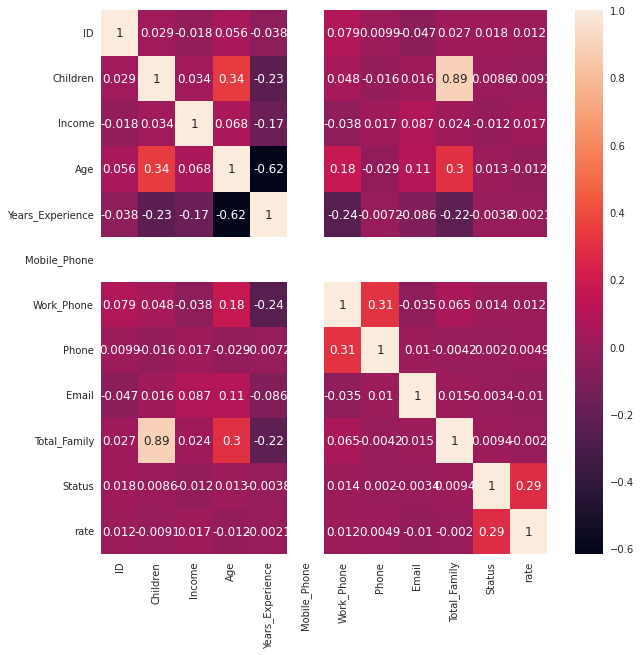

In [21]:
#Corelation between features
corr = df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot=True)
# We will remove children (beacase high correlation with total_family) 
# and Mobile_phone (has NAN correlation with others)

In [22]:
df.drop(['Children','Mobile_Phone'],axis=1,inplace=True)

### Data Preprocessing

In [23]:
# Check Missing value
df.isna().sum()/len(df)
# null values more than 25% of data

ID                  0.000000
Gender              0.000000
Car                 0.000000
Realty              0.000000
Income              0.000000
Income_Type         0.000000
Education_Type      0.000000
Family_Status       0.000000
Housing_Type        0.000000
Age                 0.000000
Years_Experience    0.000000
Work_Phone          0.000000
Phone               0.000000
Email               0.000000
Job_Title           0.310585
Total_Family        0.000000
Status              0.000000
rate                0.000000
dtype: float64

In [24]:
# filling null data 
df['Job_Title'] =df['Job_Title'].fillna('others')

In [25]:
# Convert age and YOE to year format
df['Age'] = df['Age']/(-1*365)
df['Years_Experience'] = df['Years_Experience']/(-1*365)

### Predction Baseline

In [27]:
clf1 = setup(data = df, 
             target = 'Status'
             ,train_size = 0.8
             ,categorical_features = ['Gender', 'Car', 'Realty', 'Income_Type', 'Education_Type',
                                      'Family_Status', 'Housing_Type', 'Job_Title','Work_Phone', 
                                    'Phone','Email'],
            ignore_features = ['ID'], fix_imbalance = True, silent = True,session_id=123,n_jobs=1)

,Description,Value
0,session_id,123
1,Target,Status
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(36457, 18)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,11
8,Ordinal Features,False
9,High Cardinality Features,False


In [28]:
best_model = compare_models(errors="raise")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.7250
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.8550
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.7250
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,4.1380
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,4.0940
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.2220
catboost,CatBoost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,26.8570
lr,Logistic Regression,0.9701,0.9971,0.9757,0.9706,0.9732,0.9393,0.9394,1.1300
et,Extra Trees Classifier,0.9258,0.9854,0.9246,0.9411,0.9327,0.8501,0.8503,7.5900
knn,K Neighbors Classifier,0.8806,0.9486,0.8333,0.9455,0.8858,0.7617,0.7684,1.5780


In [32]:
import warnings
evaluate_model(best_model)

,Parameters
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_impurity_split,None
min_samples_leaf,1
min_samples_split,2


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [30]:
best_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

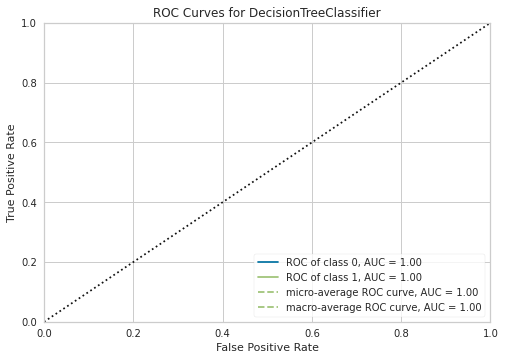

In [31]:
plot_model(best_model)

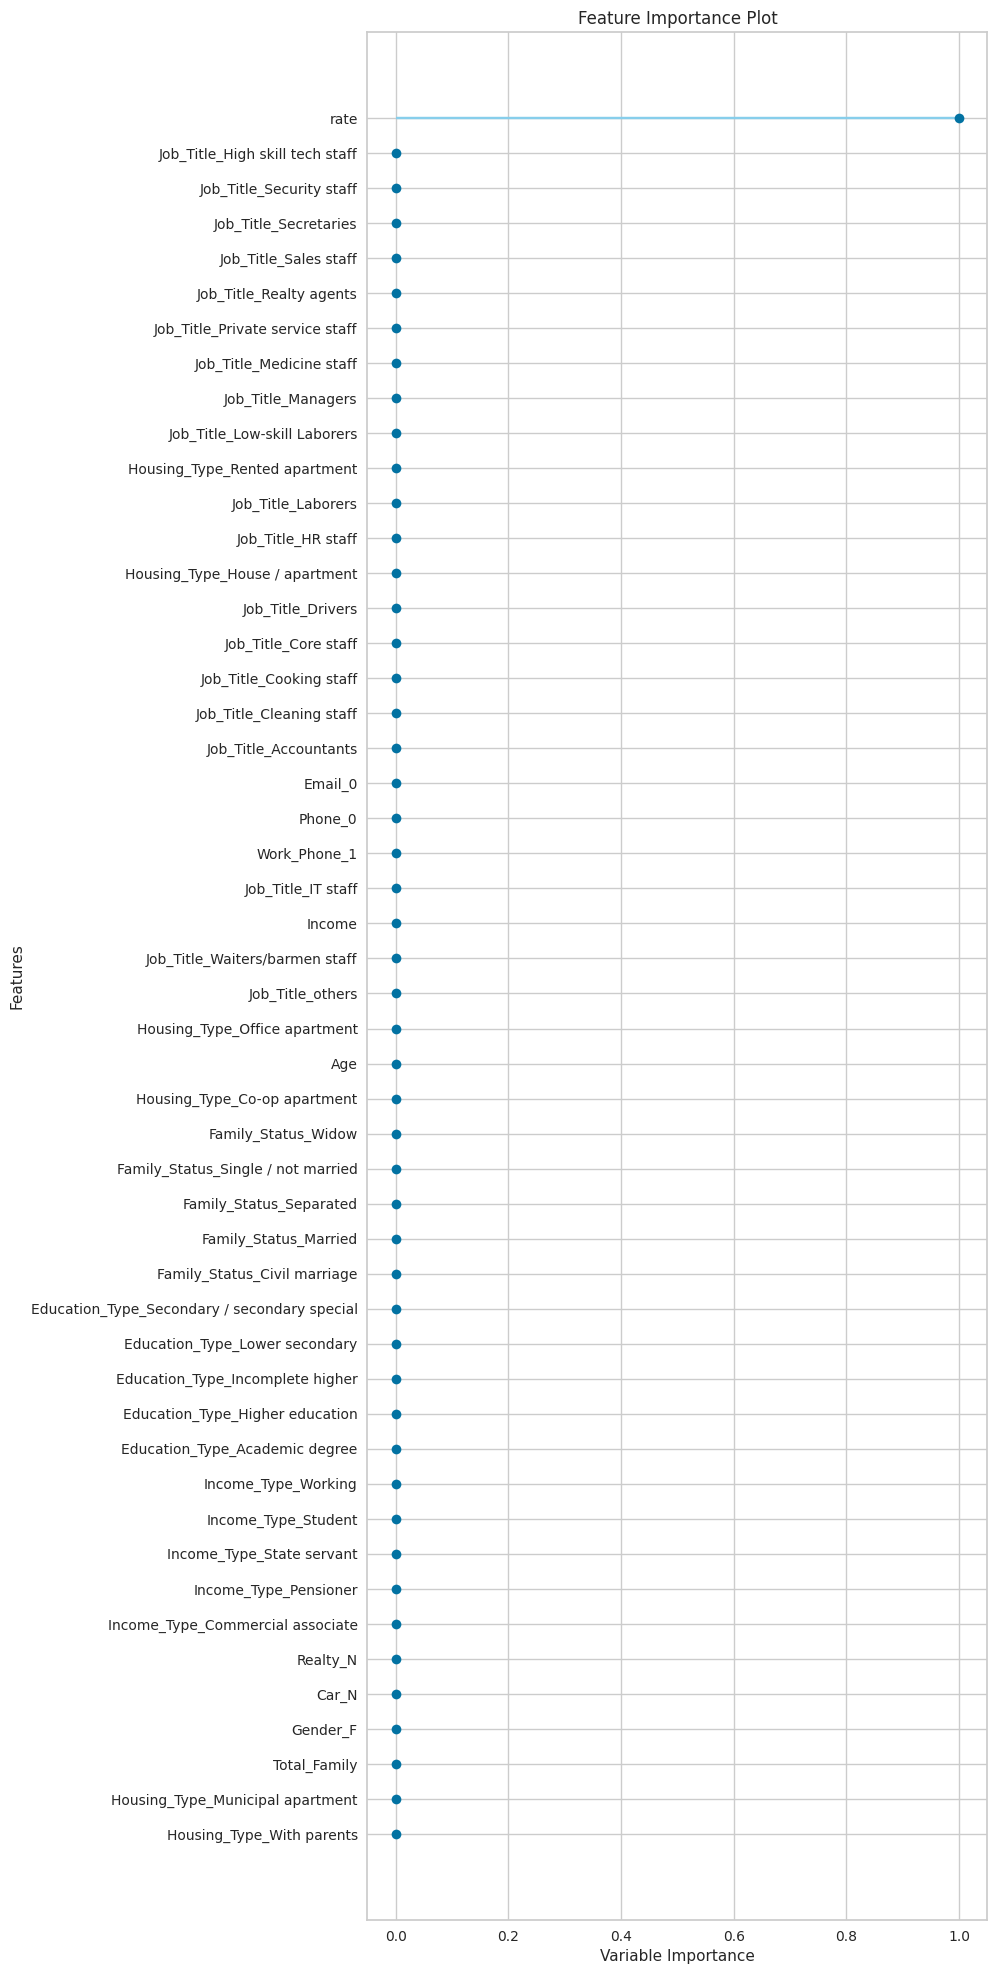

In [33]:
plot_model(best_model,'feature_all')

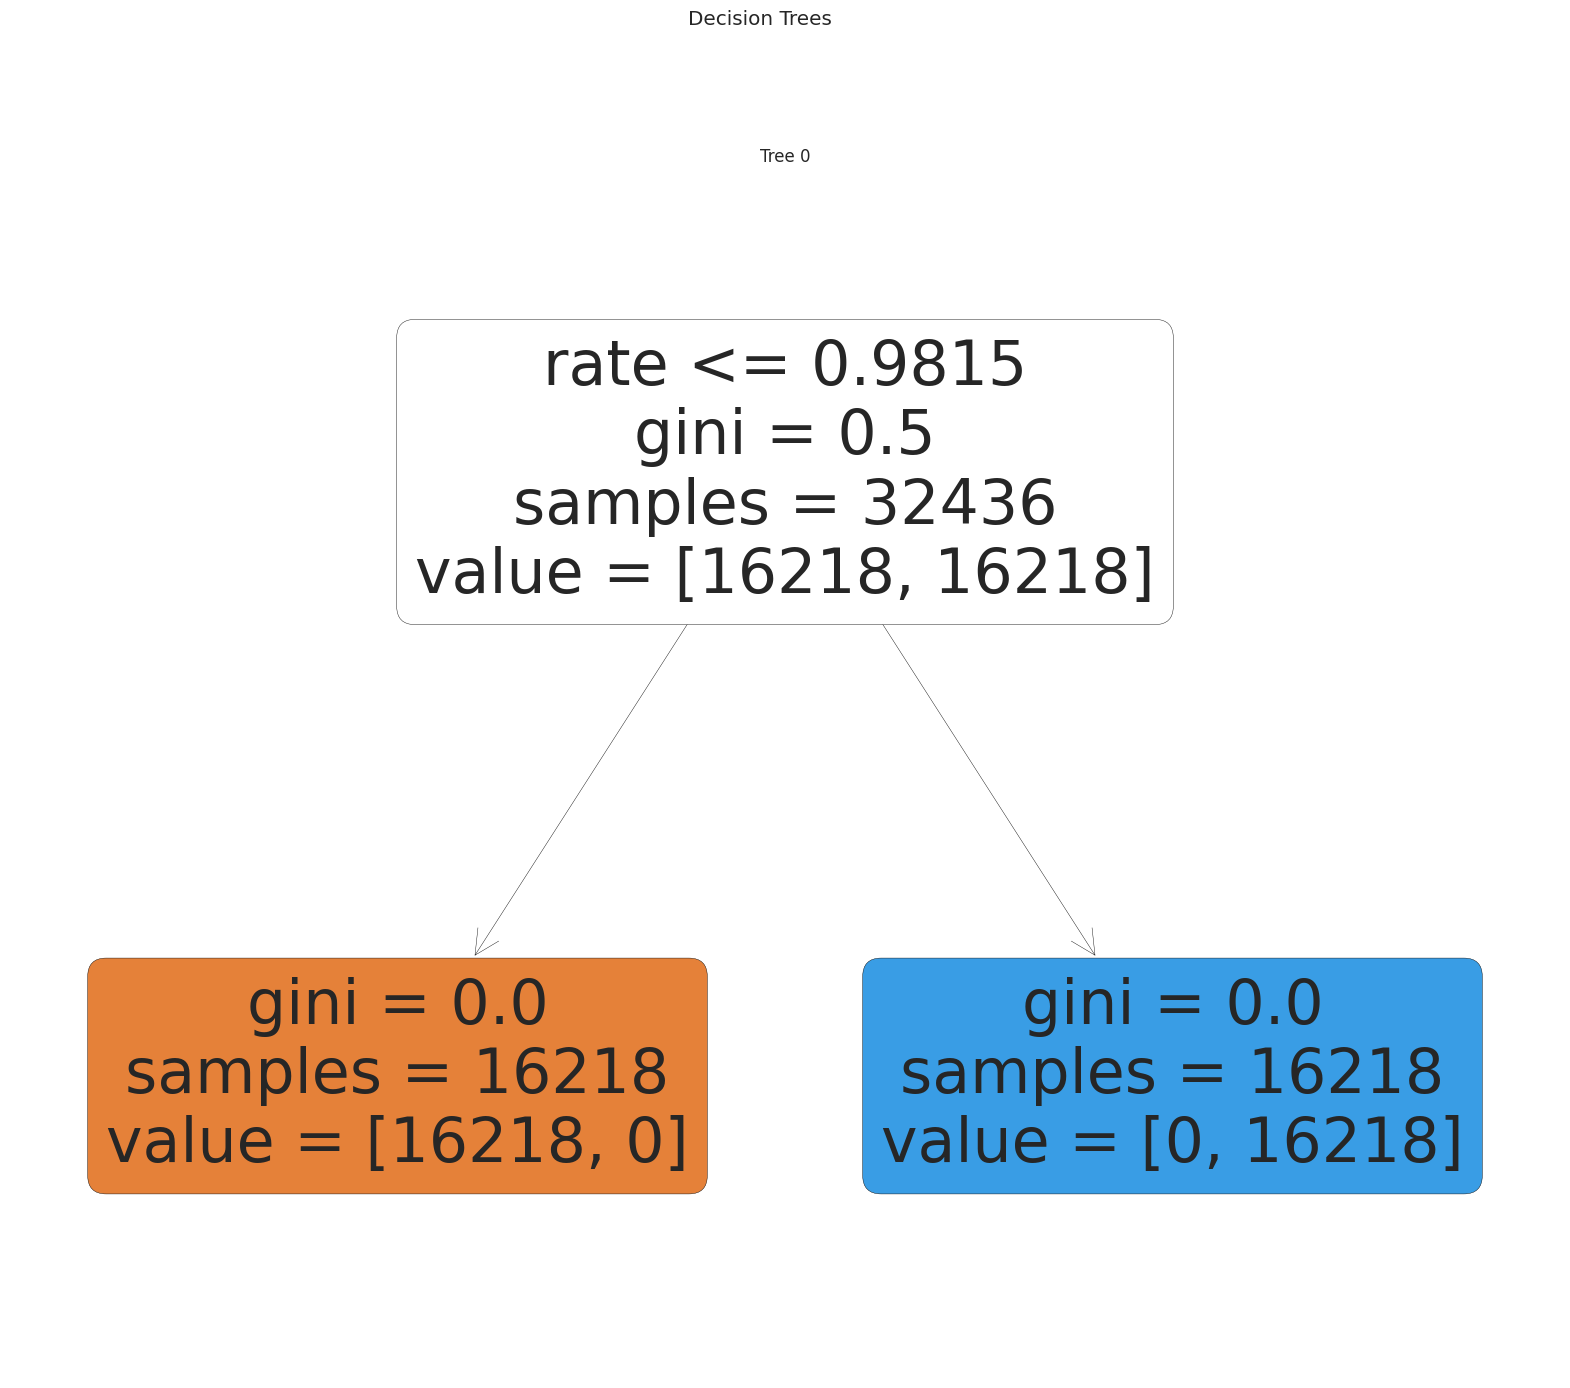

In [34]:
plot_model(best_model, plot="tree",plot_kwargs={'figsize':(20,20)})

##### Note: We can observe that customers have historical credit card data, we can predict credit scores without error (correct 100%).

In [35]:
# if new customers , 'rete' feature is not exist
# So re-modeling without 'rete' feature
df_new =df.drop('rate',axis=1)
df_new.info()
clf1 = setup(data = df_new, 
             target = 'Status'
             ,train_size = 0.8
             ,categorical_features = ['Gender', 'Car', 'Realty', 'Income_Type', 'Education_Type',
                                      'Family_Status', 'Housing_Type', 'Job_Title','Work_Phone', 
                                    'Phone','Email'],
            ignore_features = ['ID'], fix_imbalance = True,normalize=True,transformation = True, silent = True,session_id=123,n_jobs=1)

,Description,Value
0,session_id,123
1,Target,Status
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(36457, 17)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,11
8,Ordinal Features,False
9,High Cardinality Features,False


In [36]:
best_model2 = compare_models(errors="raise")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6560,0.7116,0.6989,0.6878,0.6932,0.3018,0.3020,11.5340
dt,Decision Tree Classifier,0.6503,0.6890,0.6475,0.7009,0.6731,0.2984,0.2996,5.0890
et,Extra Trees Classifier,0.6503,0.7032,0.6569,0.6969,0.6762,0.2968,0.2975,12.0490
knn,K Neighbors Classifier,0.6313,0.6704,0.6527,0.6740,0.6631,0.2561,0.2563,9.2980
xgboost,Extreme Gradient Boosting,0.6192,0.6574,0.6815,0.6506,0.6656,0.2240,0.2243,14.3370
catboost,CatBoost Classifier,0.6090,0.6481,0.6747,0.6412,0.6574,0.2027,0.2031,26.1470
lightgbm,Light Gradient Boosting Machine,0.6025,0.6375,0.6498,0.6406,0.6451,0.1934,0.1935,5.4830
gbc,Gradient Boosting Classifier,0.5479,0.5670,0.5765,0.5969,0.5864,0.0881,0.0882,10.0250
ada,Ada Boost Classifier,0.5293,0.5400,0.5342,0.5842,0.5579,0.0568,0.0571,6.3880
lr,Logistic Regression,0.5145,0.5224,0.4899,0.5745,0.5287,0.0346,0.0351,6.0550


In [31]:
best_model2

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

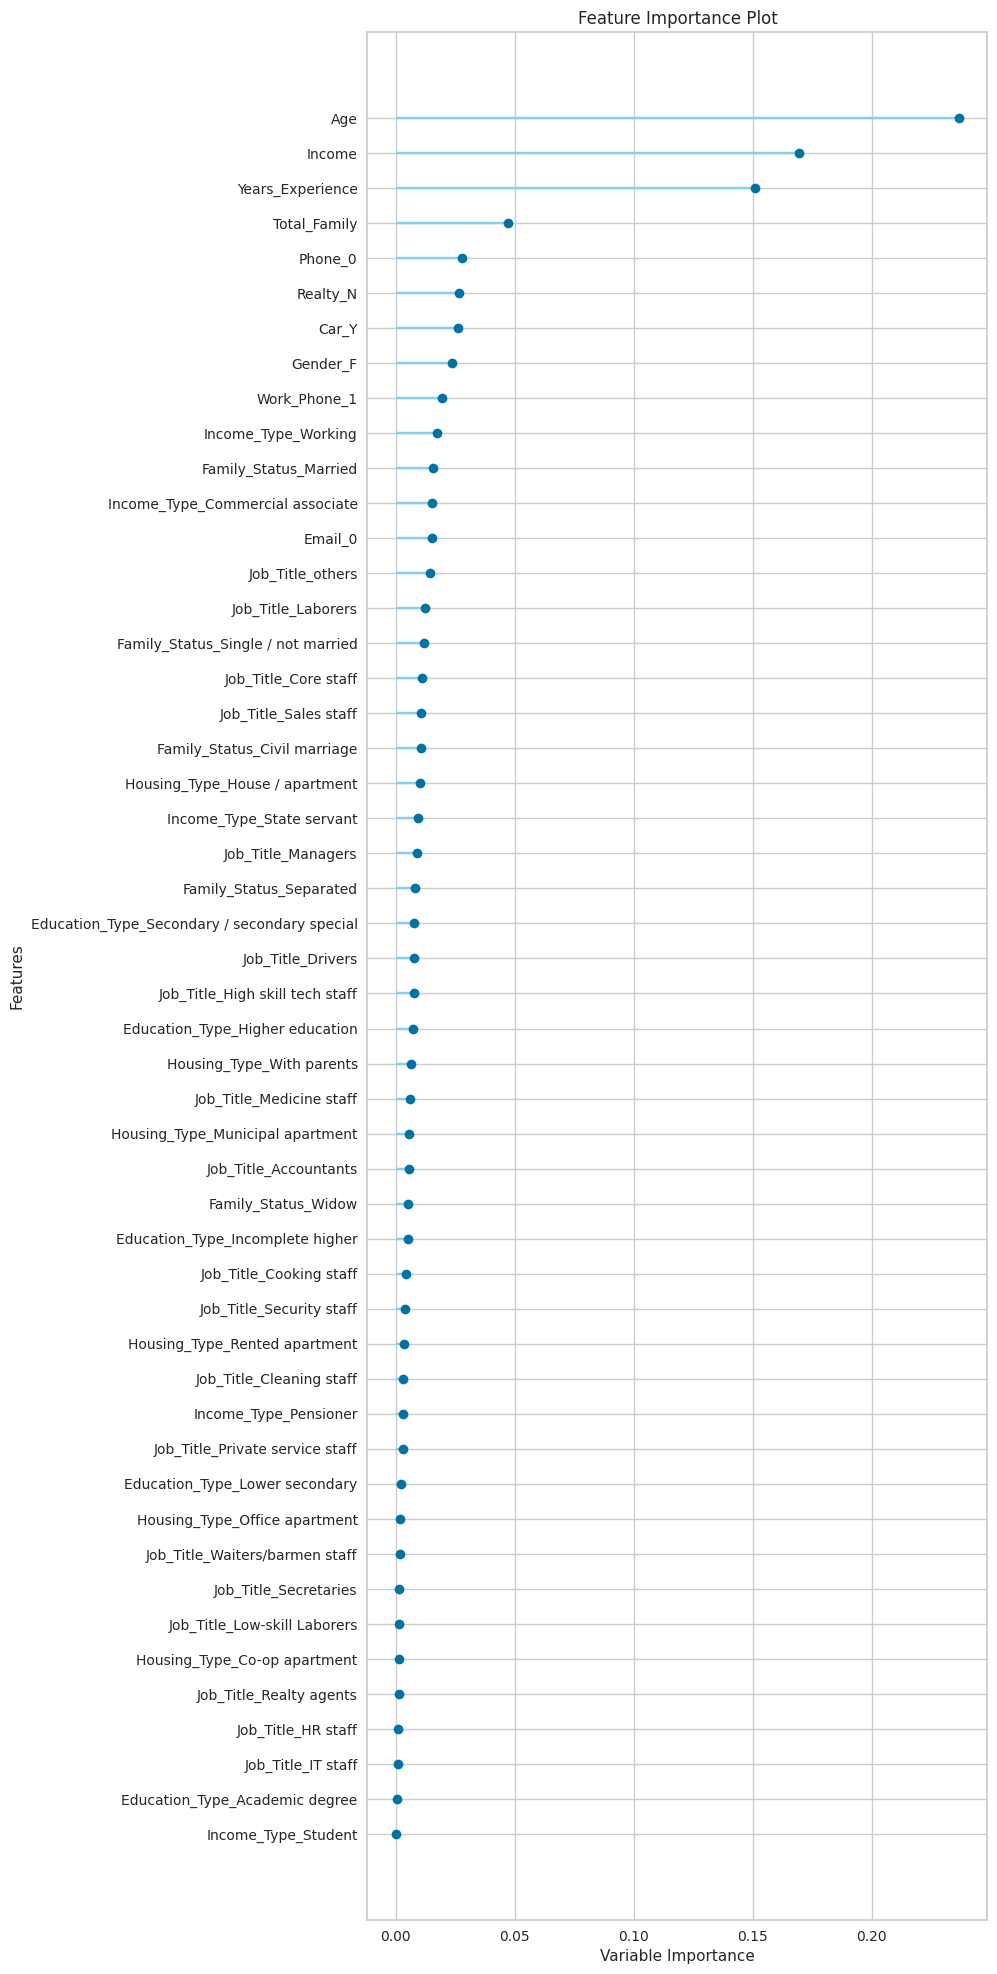

In [34]:
plot_model(best_model2,'feature_all')

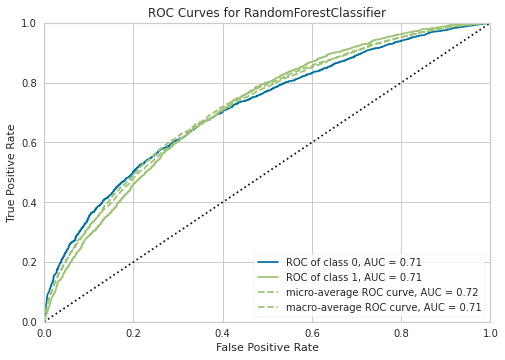

In [37]:
plot_model(best_model2)

In [38]:
evaluate_model(best_model2)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### Note: We can observe that Model have high error with New customers, it's refer that application data mey be noise since it's not useful for prediction

## Prediction Using Sklearn
### Encoding categorical columns

In [39]:
# select categorical columns
cat_col = df.select_dtypes(include=['object']).columns
# check unique values
for col in cat_col:
    print(df[col].unique())

['M' 'F']
['Y' 'N']
['Y' 'N']
['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
['others' 'Security staff' 'Sales staff' 'Accountants' 'Laborers'
 'Managers' 'Drivers' 'Core staff' 'High skill tech staff'
 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Low-skill Laborers' 'Medicine staff' 'Secretaries'
 'Waiters/barmen staff' 'HR staff' 'Realty agents' 'IT staff']


In [40]:
# Encode categorical columns
le = preprocessing.LabelEncoder()
for col in cat_col:
    df[col] = le.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                36457 non-null  int64  
 1   Gender            36457 non-null  int64  
 2   Car               36457 non-null  int64  
 3   Realty            36457 non-null  int64  
 4   Income            36457 non-null  float64
 5   Income_Type       36457 non-null  int64  
 6   Education_Type    36457 non-null  int64  
 7   Family_Status     36457 non-null  int64  
 8   Housing_Type      36457 non-null  int64  
 9   Age               36457 non-null  float64
 10  Years_Experience  36457 non-null  float64
 11  Work_Phone        36457 non-null  int64  
 12  Phone             36457 non-null  int64  
 13  Email             36457 non-null  int64  
 14  Job_Title         36457 non-null  int64  
 15  Total_Family      36457 non-null  float64
 16  Status            36457 non-null  int64 

### Train Test split

In [41]:
# Stratified split validation and train dataset
# because there are unbalance data
X = df.drop(['ID','Status'],axis = 1)
y = df['Status']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y,random_state=42)

In [42]:
y_val.value_counts(normalize=True)

1    0.554169
0    0.445831
Name: Status, dtype: float64

In [43]:
y_train.value_counts(normalize=True)

1    0.554157
0    0.445843
Name: Status, dtype: float64

### Oversampling To handle imbalance

In [44]:
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train,y_train)
y_train.value_counts(normalize=True)

1    0.5
0    0.5
Name: Status, dtype: float64

### Transformation to handle skewness

In [45]:
power = PowerTransformer()
X_train = power.fit_transform(X_train)
X_val = power.fit_transform(X_val)

In [46]:
# Scaling data 
normalizer = preprocessing.StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.fit_transform(X_val)

### Feature importance 

In [48]:
from sklearn.metrics import *
lr_model = LogisticRegression(C=1, penalty='l1', solver='liblinear',random_state=123)
lr_model.fit(X_train, y_train)
y_predict = lr_model.predict(X_val)
print("Accuracy = " , accuracy_score(y_val, y_predict))
print("F1 = " , f1_score(y_val, y_predict))

Accuracy =  0.9566648381788261
F1 =  0.9593098120010302


In [49]:
importance = pd.DataFrame(lr_model.coef_[0], 
             df.drop(['ID','Status'],axis = 1).columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

<AxesSubplot:>

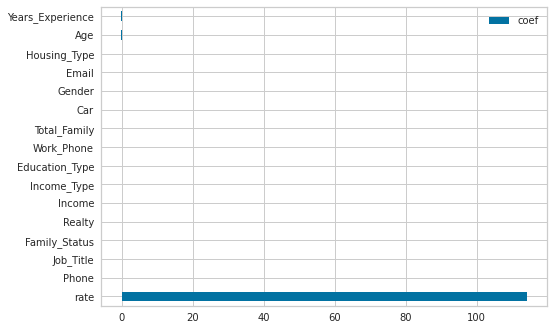

In [50]:
importance.plot(kind = "barh")

shape of reduction data by ratio=0.95 (39616, 14)


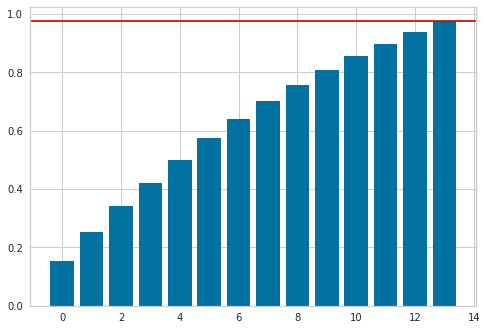

In [51]:
pca=PCA(0.95)
pca.fit(np.concatenate([X_train,X_val]))
PCA_df = pca.transform(np.concatenate([X_train,X_val]))
print('shape of reduction data by ratio=0.95', PCA_df.shape)
cumsum = pca.explained_variance_ratio_.cumsum()
n_components= pca.n_components_
plt.bar(np.arange(len(cumsum)),cumsum)
plt.axhline(y=cumsum[n_components-1], color='r', linestyle='-')
plt.show()